In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow import keras
# from numba import cuda

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2 
from tensorflow.keras.applications.resnet_v2 import ResNet101V2

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, roc_curve

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import gc

print("Loading Libraries Done")

c:\Users\91997\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Loading Libraries Done


In [2]:
main_folder = "Autism dataset\consolidated"
RANDOM_SEED = 6

categories = os.listdir(main_folder)
try:
    categories.remove(".DS_Store")
except:
    pass
print(categories, len(categories))


['Autistic', 'Non_Autistic'] 2


In [3]:
TOTAL_CATEGORIES = len(categories)
IMAGE_SIZE = (224,224,3)

def load_images_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        print(index, category)
        for image_name in tqdm(os.listdir(main_folder+"/"+category)):
            file_ext = image_name.split(".")[-1]
            if (file_ext.lower() == "jpg") or (file_ext.lower() == "jpeg") or (file_ext.lower() == "png") or (file_ext.lower() == "bmp"):
              try:
                    imgname = main_folder+"/"+category+"/"+image_name
                    imgname = imgname.replace("//", "/")
                    img = cv2.imread(imgname)
                    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    img_rotated_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                    img_rotated_180 = cv2.rotate(img, cv2.ROTATE_180)
                    img_rotated_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                    img_flip_ver = cv2.flip(img, 0)
                    img_flip_hor = cv2.flip(img, 1)

                    img_array = Image.fromarray(img, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_90, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_90, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_180, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_270, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_flip_ver, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_flip_hor, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

              except:
                    print(imgname)
                    print(img)
                

    return img_lst, labels

images, labels = load_images_labels(categories)
print()
print("Total Images Loaded:", len(images))

0 Autistic


100%|██████████| 1470/1470 [00:04<00:00, 360.40it/s]


1 Non_Autistic


100%|██████████| 1470/1470 [00:03<00:00, 389.20it/s]


Total Images Loaded: 2940


In [4]:
images = np.array(images)
labels = np.array(labels)

In [5]:
images = images.astype(np.float32)
labels = labels.astype(np.int8)
images /= 255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (2940, 224, 224, 3)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = RANDOM_SEED)

x_train = x_train[:1500]
y_train = y_train[:1500]

x_val = x_test[:500]
y_val = y_test[:500]

x_test = x_test[500:1000]
y_test = y_test[500:1000]

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("x_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)
print("x_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (1500, 224, 224, 3)
y_train shape =  (1500,)
x_val shape =  (500, 224, 224, 3)
y_val shape =  (500,)
x_test shape =  (88, 224, 224, 3)
y_test shape =  (88,)


In [7]:
del labels
del images

# VGG19 model

In [8]:
EPOCHS = 60
BATCH_SIZE = 16

In [9]:
vgg = VGG19(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [10]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [11]:
x = Flatten()(vgg.output)

# three hidden layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
vgg_model = Model(inputs=vgg.input, outputs=prediction)
vgg_model.summary()# view the structure of the model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [13]:
#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=5, restore_best_weights=True)

In [14]:
# fit the model
vgg_history = vgg_model.fit(x_train, y_train, validation_data=(x_val,y_val), steps_per_epoch = 10, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_val.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/60
10/10 [==============================] - 11s 320ms/step - loss: 1.0821 - accuracy: 0.5750 - val_loss: 3.8590 - val_accuracy: 0.4879
Epoch 2/60
10/10 [==============================] - 3s 271ms/step - loss: 0.8076 - accuracy: 0.6562 - val_loss: 5.4130 - val_accuracy: 0.4879
Epoch 3/60
10/10 [==============================] - 3s 273ms/step - loss: 0.9301 - accuracy: 0.6625 - val_loss: 4.6827 - val_accuracy: 0.4879
Epoch 4/60
10/10 [==============================] - 3s 277ms/step - loss: 0.6932 - accuracy: 0.7437 - val_loss: 3.5843 - val_accuracy: 0.4879
Epoch 5/60
10/10 [==============================] - 3s 277ms/step - loss: 0.8108 - accuracy: 0.6500 - val_loss: 2.6390 - val_accuracy: 0.4879
Epoch 6/60
10/10 [==============================] - 3s 276ms/step - loss: 0.7136 - accuracy: 0.6812 - val_loss: 1.8288 - val_accuracy: 0.4980
Epoch 7/60
10/10 [==============================] - 3s 277ms/step - loss: 0.6907 - accuracy: 0.6812 - val_loss: 1.5763 - val_accuracy: 0.4940
Epoch

In [15]:
tf.keras.backend.clear_session()
vgg_loss, vgg_acc = vgg_model.evaluate(x_test,y_test,batch_size=32)
print("VGG 19 Loss:", vgg_loss)
print("VGG 19 Accuracy:", vgg_acc*100, "%")

3/3 [==============================] - 4s 794ms/step - loss: 0.8811 - accuracy: 0.6591
VGG 19 Loss: 0.8810922503471375
VGG 19 Accuracy: 65.90909361839294 %


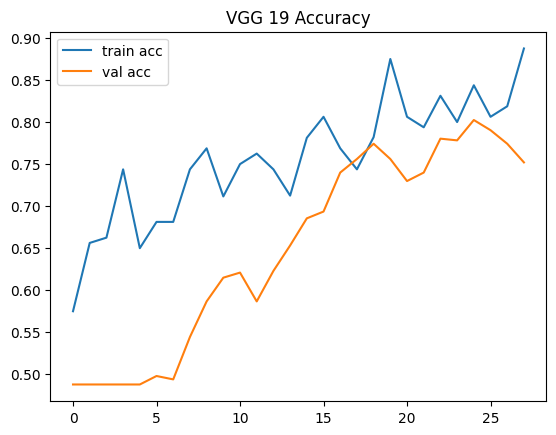

In [16]:
# accuracies
plt.plot(vgg_history.history['accuracy'], label='train acc')
plt.plot(vgg_history.history['val_accuracy'], label='val acc')
plt.title("VGG 19 Accuracy")
plt.legend()
plt.show()

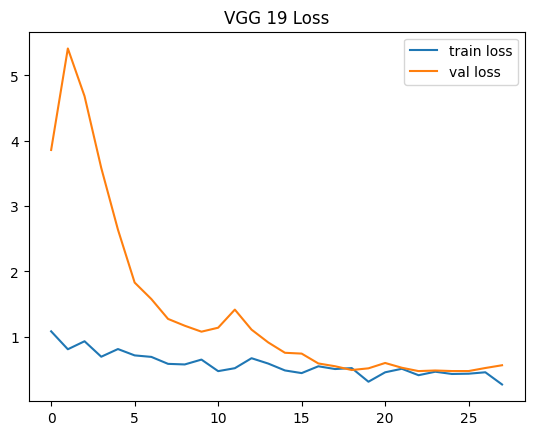

In [17]:
# loss
plt.plot(vgg_history.history['loss'], label='train loss')
plt.plot(vgg_history.history['val_loss'], label='val loss')
plt.title("VGG 19 Loss")
plt.legend()
plt.show()

In [18]:
#predict
y_pred = vgg_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
print(classification_report(y_pred,y_test))#get classification report

3/3 [==============================] - 0s 110ms/step
              precision    recall  f1-score   support

           0       0.79      0.62      0.69        55
           1       0.53      0.73      0.62        33

    accuracy                           0.66        88
   macro avg       0.66      0.67      0.65        88
weighted avg       0.69      0.66      0.66        88



[[34 21]
 [ 9 24]]
3/3 [==============================] - 0s 111ms/step


C:\Users\91997\AppData\Local\Temp\ipykernel_16476\1455436863.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


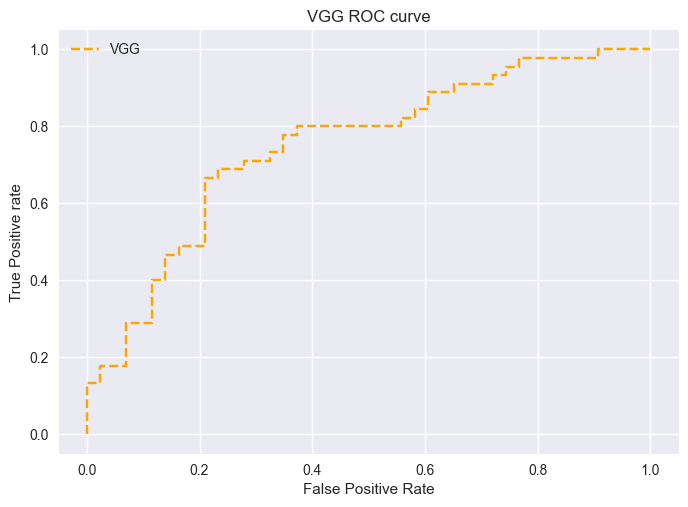

In [19]:
print(confusion_matrix(y_pred,y_test))
pred_prob1 =vgg_model.predict(x_test)
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)

plt.style.use('seaborn')

plt.plot(fpr1, tpr1, linestyle='--',color='orange', label=r'VGG')
plt.title('VGG ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

In [20]:
vgg_model.save("Model\AutismDetection_vgg_model.h5", save_format="h5")

del vgg_history
del y_pred

gc.collect()

9910

# RESNET50 model

In [21]:
resnet_50 = ResNet50(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [22]:
#do not train the pre-trained layers of VGG-19
for layer in resnet_50.layers:
    layer.trainable = False

In [23]:
x = Flatten()(resnet_50.output)

#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_50_model = Model(inputs=resnet_50.input, outputs=prediction)
resnet_50_model.summary()# view the structure of the model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

 conv2_block1_0_conv (Conv2D)   (None, 56, 56, 256)  16640       ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block1_2_relu[0][0]']    
                                                                                                  
 conv2_block1_0_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

In [24]:
resnet_50_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=15, restore_best_weights=True)

# fit the model
resnet_50_history = resnet_50_model.fit(x_train, y_train, validation_data=(x_val,y_val), steps_per_epoch = 10, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_val.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/60
10/10 [==============================] - 5s 274ms/step - loss: 5.3845 - accuracy: 0.5125 - val_loss: 2.6725 - val_accuracy: 0.4879
Epoch 2/60
10/10 [==============================] - 1s 155ms/step - loss: 2.9025 - accuracy: 0.5250 - val_loss: 1.1919 - val_accuracy: 0.4879
Epoch 3/60
10/10 [==============================] - 2s 166ms/step - loss: 1.4444 - accuracy: 0.5000 - val_loss: 0.8389 - val_accuracy: 0.5524
Epoch 4/60
10/10 [==============================] - 2s 165ms/step - loss: 0.7877 - accuracy: 0.6250 - val_loss: 0.6929 - val_accuracy: 0.6532
Epoch 5/60
10/10 [==============================] - 1s 155ms/step - loss: 0.6998 - accuracy: 0.6000 - val_loss: 1.0596 - val_accuracy: 0.4879
Epoch 6/60
10/10 [==============================] - 1s 155ms/step - loss: 1.0507 - accuracy: 0.5750 - val_loss: 1.1602 - val_accuracy: 0.5262
Epoch 7/60
10/10 [==============================] - 2s 165ms/step - loss: 0.9418 - accuracy: 0.5500 - val_loss: 0.6185 - val_accuracy: 0.6754
Epoch 

In [25]:
resnet_50_loss,resnet_50_acc = resnet_50_model.evaluate(x_test,y_test,batch_size=32)
print("Resnet_50 Loss:", resnet_50_loss)
print("Resnet_50 Accuracy:", resnet_50_acc*100, "%")

3/3 [==============================] - 0s 97ms/step - loss: 0.7012 - accuracy: 0.7159
Resnet_50 Loss: 0.7011623382568359
Resnet_50 Accuracy: 71.59090638160706 %


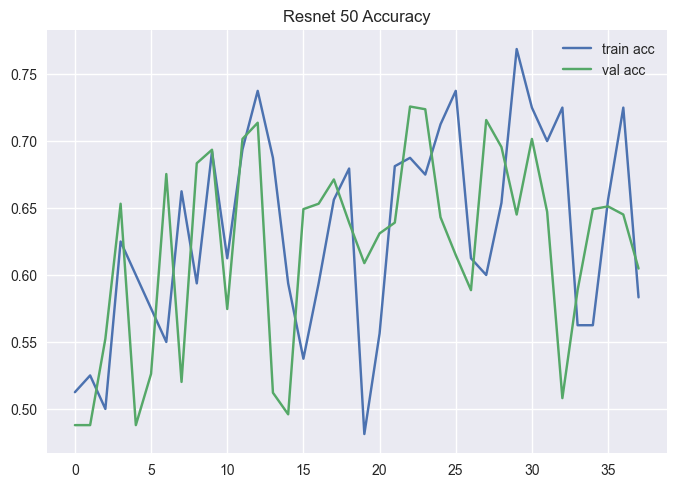

In [26]:
# accuracies
plt.plot(resnet_50_history.history['accuracy'], label='train acc')
plt.plot(resnet_50_history.history['val_accuracy'], label='val acc')
plt.title("Resnet 50 Accuracy")
plt.legend()
plt.show()

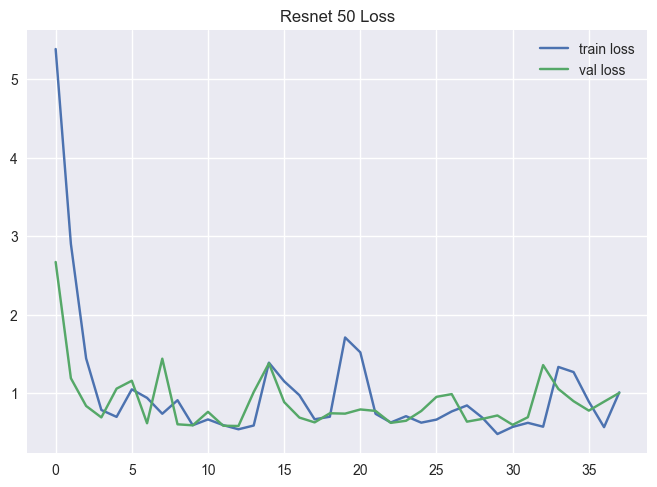

In [27]:
# loss
plt.plot(resnet_50_history.history['loss'], label='train loss')
plt.plot(resnet_50_history.history['val_loss'], label='val loss')
plt.title("Resnet 50 Loss")
plt.legend()
plt.show()

In [28]:
#predict
y_pred=resnet_50_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

3/3 [==============================] - 1s 61ms/step
              precision    recall  f1-score   support

           0       0.84      0.67      0.74        54
           1       0.60      0.79      0.68        34

    accuracy                           0.72        88
   macro avg       0.72      0.73      0.71        88
weighted avg       0.75      0.72      0.72        88



[[36 18]
 [ 7 27]]


3/3 [==============================] - 0s 110ms/step


C:\Users\91997\AppData\Local\Temp\ipykernel_16476\661079358.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


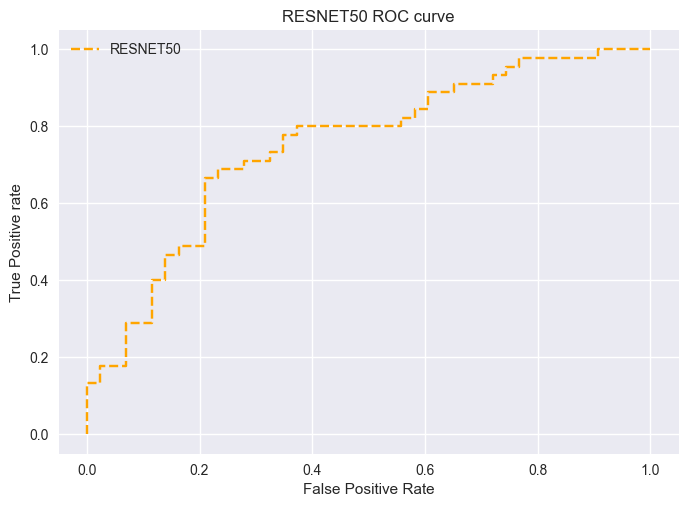

In [29]:
print(confusion_matrix(y_pred,y_test))
pred_prob2 =vgg_model.predict(x_test)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)

plt.style.use('seaborn')

plt.plot(fpr2, tpr2, linestyle='--',color='orange', label=r'RESNET50')
plt.title('RESNET50 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

In [30]:
resnet_50_model.save("Model\AutismDetection_resnet_50_model.h5", save_format="h5")

del resnet_50_history
del y_pred

gc.collect()

6464

# RESNET50 V2

In [31]:
resnet_50_v2 = ResNet50V2(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [32]:
#do not train the pre-trained layers of VGG-19
for layer in resnet_50_v2.layers:
    layer.trainable = False

In [33]:
x = Flatten()(resnet_50_v2.output)

# three hidden layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)


#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_50_v2_model = Model(inputs=resnet_50_v2.input, outputs=prediction)
# view the structure of the model
resnet_50_v2_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [34]:
resnet_50_v2_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['acc'])

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=15, restore_best_weights=True)

# fit the model
resnet_50_v2_history = resnet_50_v2_model.fit(x_train, y_train, validation_data=(x_val,y_val), steps_per_epoch = 10, epochs=150, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_val.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/150
10/10 [==============================] - 5s 247ms/step - loss: 1.0352 - acc: 0.5875 - val_loss: 1.1812 - val_acc: 0.6270
Epoch 2/150
10/10 [==============================] - 1s 158ms/step - loss: 0.6613 - acc: 0.6625 - val_loss: 1.1707 - val_acc: 0.6552
Epoch 3/150
10/10 [==============================] - 1s 159ms/step - loss: 0.7497 - acc: 0.7500 - val_loss: 1.0451 - val_acc: 0.6472
Epoch 4/150
10/10 [==============================] - 1s 157ms/step - loss: 0.7341 - acc: 0.7000 - val_loss: 0.9770 - val_acc: 0.6169
Epoch 5/150
10/10 [==============================] - 1s 158ms/step - loss: 0.7568 - acc: 0.6812 - val_loss: 0.8640 - val_acc: 0.5948
Epoch 6/150
10/10 [==============================] - 1s 157ms/step - loss: 0.6833 - acc: 0.6812 - val_loss: 0.8433 - val_acc: 0.6028
Epoch 7/150
10/10 [==============================] - 1s 158ms/step - loss: 0.7411 - acc: 0.6375 - val_loss: 0.8209 - val_acc: 0.6250
Epoch 8/150
10/10 [==============================] - 1s 157ms/step - 

In [35]:
resnet_50_v2_loss,resnet_50_v2_acc = resnet_50_v2_model.evaluate(x_test,y_test,batch_size=32)
print("Resnet_50_V2 Loss:", resnet_50_v2_loss)
print("Resnet_50_V2 Accuracy:", resnet_50_v2_acc*100, "%")

3/3 [==============================] - 0s 78ms/step - loss: 1.0218 - acc: 0.7045
Resnet_50_V2 Loss: 1.021807312965393
Resnet_50_V2 Accuracy: 70.45454382896423 %


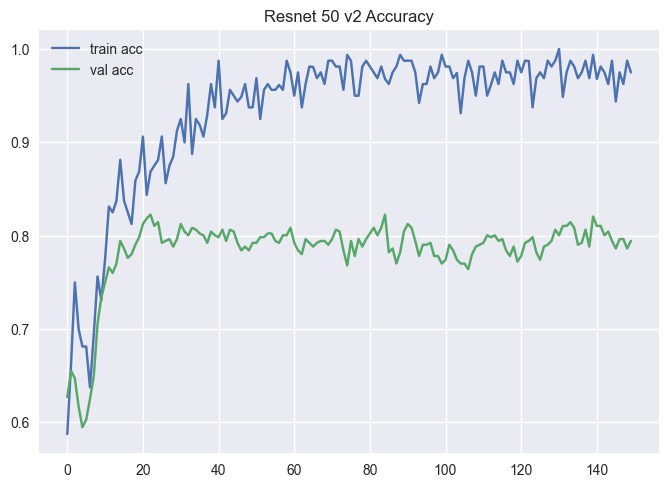

In [36]:
# accuracies
plt.plot(resnet_50_v2_history.history['acc'], label='train acc')
plt.plot(resnet_50_v2_history.history['val_acc'], label='val acc')
plt.title("Resnet 50 v2 Accuracy")
plt.legend()
plt.show()

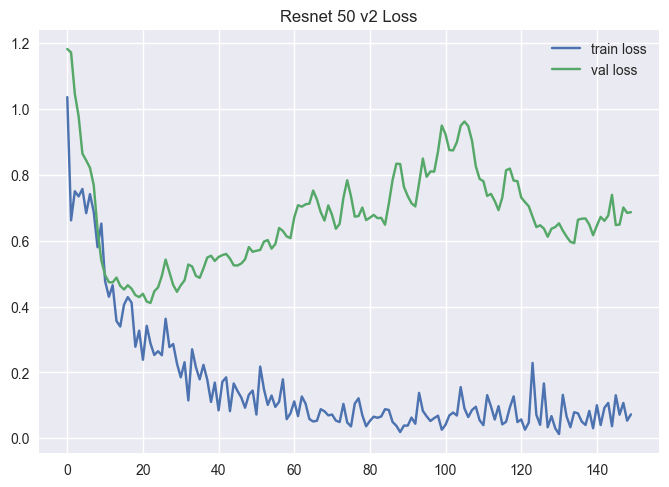

In [37]:
# loss
plt.plot(resnet_50_v2_history.history['loss'], label='train loss')
plt.plot(resnet_50_v2_history.history['val_loss'], label='val loss')
plt.title("Resnet 50 v2 Loss")
plt.legend()
plt.show()

In [38]:
#predict
y_pred=resnet_50_v2_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

3/3 [==============================] - 1s 54ms/step
              precision    recall  f1-score   support

           0       0.72      0.69      0.70        45
           1       0.69      0.72      0.70        43

    accuracy                           0.70        88
   macro avg       0.70      0.70      0.70        88
weighted avg       0.71      0.70      0.70        88



[[31 14]
 [12 31]]


3/3 [==============================] - 0s 109ms/step


C:\Users\91997\AppData\Local\Temp\ipykernel_16476\1837746427.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


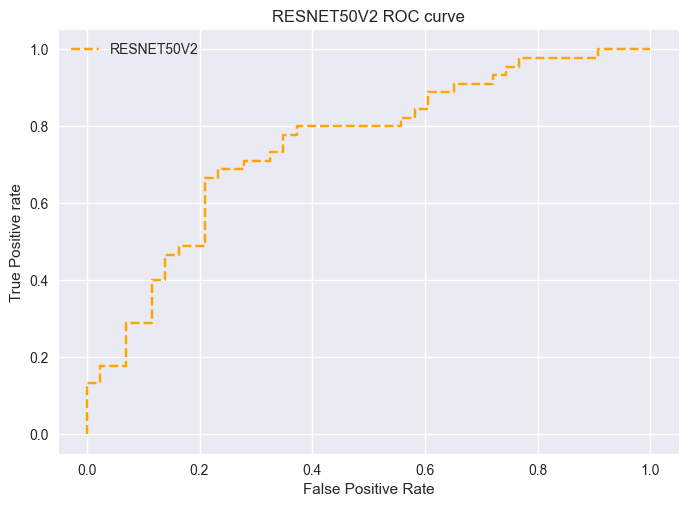

In [39]:
print(confusion_matrix(y_pred,y_test))
pred_prob3 =vgg_model.predict(x_test)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)

plt.style.use('seaborn')

plt.plot(fpr3, tpr3, linestyle='--',color='orange', label=r'RESNET50V2')
plt.title('RESNET50V2 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

In [40]:
resnet_50_v2_model.save("Model\AutismDetection_resnet_50_v2_model.h5", save_format="h5")

del resnet_50_v2_history
del y_pred

gc.collect()

13825

# RESNET101V2

In [41]:
resnet_101_v2 = ResNet101V2(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [42]:
#do not train the pre-trained layers of VGG-19
for layer in resnet_101_v2.layers:
    layer.trainable = False

In [43]:
x = Flatten()(resnet_101_v2.output)

# three hidden layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)


#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_101_v2_model = Model(inputs=resnet_101_v2.input, outputs=prediction)
# view the structure of the model
resnet_101_v2_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [44]:
resnet_101_v2_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['acc'])

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=15, restore_best_weights=True)

# fit the model
resnet_101_v2_history = resnet_101_v2_model.fit(x_train, y_train, validation_data=(x_val,y_val), steps_per_epoch = 10, epochs=150, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_val.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/150
10/10 [==============================] - 9s 441ms/step - loss: 0.8734 - acc: 0.5938 - val_loss: 2.0154 - val_acc: 0.5323
Epoch 2/150
10/10 [==============================] - 3s 282ms/step - loss: 0.7482 - acc: 0.6625 - val_loss: 1.2939 - val_acc: 0.6391
Epoch 3/150
10/10 [==============================] - 3s 282ms/step - loss: 0.7537 - acc: 0.6875 - val_loss: 0.9698 - val_acc: 0.6633
Epoch 4/150
10/10 [==============================] - 3s 283ms/step - loss: 0.7123 - acc: 0.6938 - val_loss: 0.7595 - val_acc: 0.6694
Epoch 5/150
10/10 [==============================] - 3s 283ms/step - loss: 0.6593 - acc: 0.7625 - val_loss: 0.6601 - val_acc: 0.6915
Epoch 6/150
10/10 [==============================] - 3s 284ms/step - loss: 0.6877 - acc: 0.7063 - val_loss: 0.6505 - val_acc: 0.6694
Epoch 7/150
10/10 [==============================] - 3s 283ms/step - loss: 0.7042 - acc: 0.6562 - val_loss: 0.6201 - val_acc: 0.7036
Epoch 8/150
10/10 [==============================] - 3s 284ms/step - 

In [45]:
resnet_101_v2_loss,resnet_101_v2_acc = resnet_101_v2_model.evaluate(x_test,y_test,batch_size=32)
print("resnet_101_v2 Loss:", resnet_101_v2_loss)
print("resnet_101_v2 Accuracy:", resnet_101_v2_acc*100, "%")

3/3 [==============================] - 0s 86ms/step - loss: 0.9396 - acc: 0.7727
resnet_101_v2 Loss: 0.9396291971206665
resnet_101_v2 Accuracy: 77.27272510528564 %


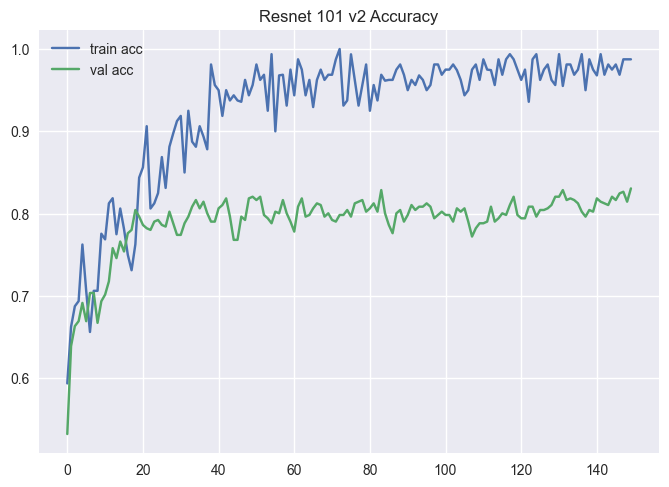

In [46]:
# accuracies
plt.plot(resnet_101_v2_history.history['acc'], label='train acc')
plt.plot(resnet_101_v2_history.history['val_acc'], label='val acc')
plt.title("Resnet 101 v2 Accuracy")
plt.legend()
plt.show()

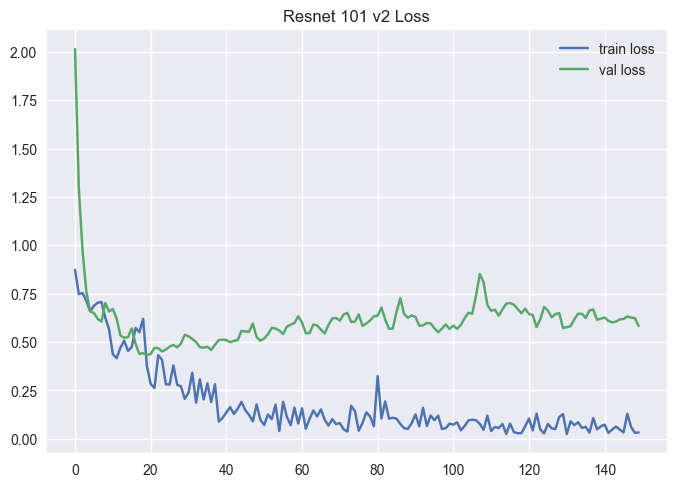

In [47]:
# loss
plt.plot(resnet_101_v2_history.history['loss'], label='train loss')
plt.plot(resnet_101_v2_history.history['val_loss'], label='val loss')
plt.title("Resnet 101 v2 Loss")
plt.legend()
plt.show()

In [48]:
#predict
y_pred=resnet_101_v2_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

3/3 [==============================] - 2s 171ms/step
              precision    recall  f1-score   support

           0       0.74      0.78      0.76        41
           1       0.80      0.77      0.78        47

    accuracy                           0.77        88
   macro avg       0.77      0.77      0.77        88
weighted avg       0.77      0.77      0.77        88



[[32  9]
 [11 36]]
3/3 [==============================] - 0s 111ms/step


C:\Users\91997\AppData\Local\Temp\ipykernel_16476\4160645141.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


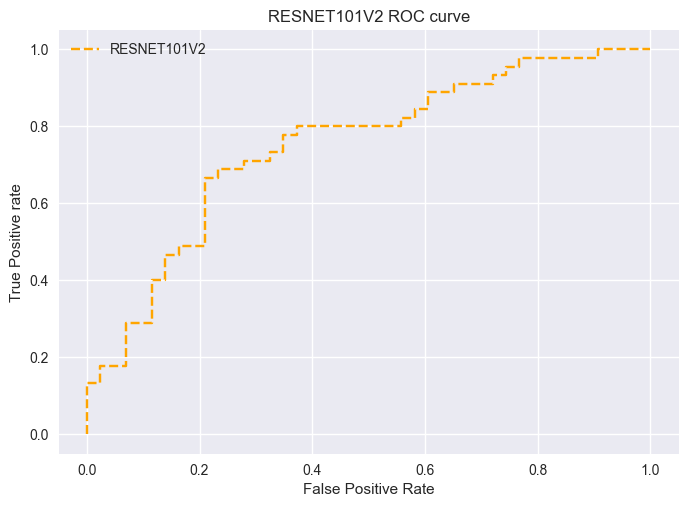

In [49]:
print(confusion_matrix(y_pred,y_test))
pred_prob4 =vgg_model.predict(x_test)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob4[:,1], pos_label=1)

plt.style.use('seaborn')

plt.plot(fpr4, tpr4, linestyle='--',color='orange', label=r'RESNET101V2')
plt.title('RESNET101V2 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

In [50]:
resnet_101_v2_model.save("Model\AutismDetection_resnet_101_v2_model.h5", save_format="h5")

del resnet_101_v2_history
del y_pred

gc.collect()

9275

# Model comparision

[65.90909361839294, 71.59090638160706, 70.45454382896423, 77.27272510528564]


Text(0.5, 1.0, 'Accuracy score Comparison (Higher is better)')

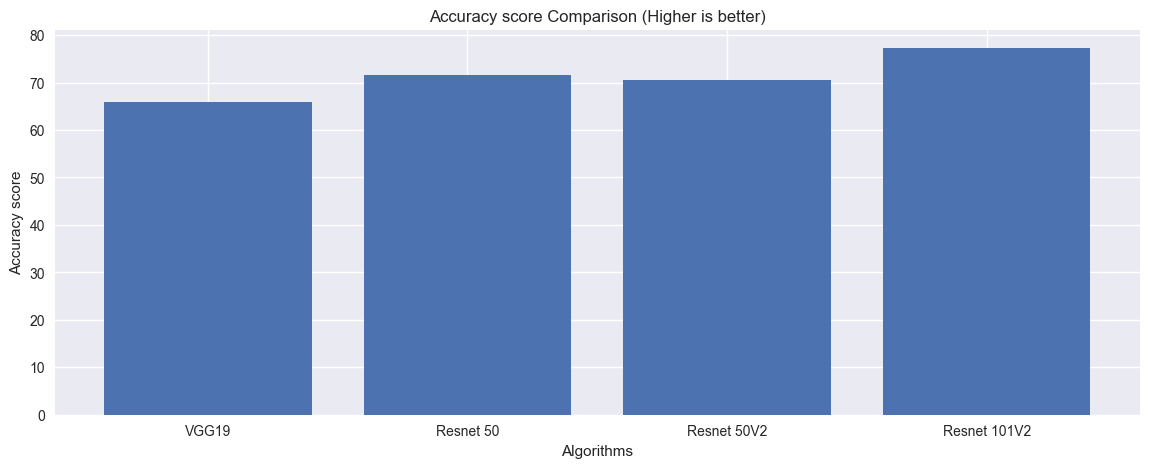

In [51]:
algorithms = ["VGG19","Resnet 50","Resnet 50V2","Resnet 101V2"]
Accuracy = [vgg_acc*100,resnet_50_acc*100,resnet_50_v2_acc*100,resnet_101_v2_acc*100]
print(Accuracy)

plt.figure(figsize=[14,5])
plt.bar(algorithms, Accuracy)
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")
plt.title("Accuracy score Comparison (Higher is better)")